In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Ponencia clasificacón de imagenes"

/content/drive/MyDrive/Colab Notebooks/Ponencia clasificacón de imagenes


In [ ]:
#!unzip autos.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
DATA = './autos'

In [ ]:
batch_size = 32
img_height = 160
img_width = 160
epochs=5

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 332 files belonging to 3 classes.
Using 266 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 332 files belonging to 3 classes.
Using 66 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['audi', 'ferrari', 'volkswagen']


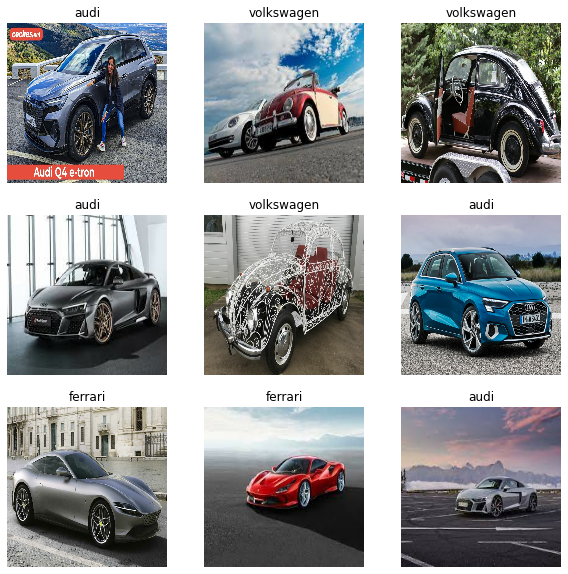

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 160, 160, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    #layers.RandomFlip("vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.3),
  ]
)


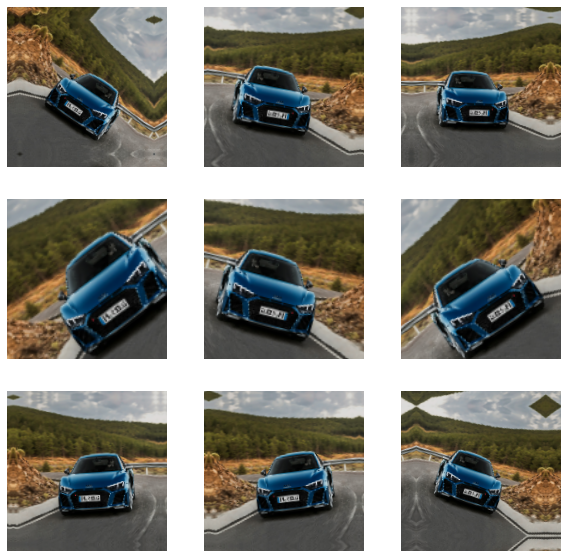

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_width, img_width)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0006
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
9/9 [==============================] - 7s 321ms/step - loss: 1.3501 - accuracy: 0.3421 - val_loss: 0.9826 - val_accuracy: 0.4545
Epoch 2/10
9/9 [==============================] - 1s 69ms/step - loss: 1.2456 - accuracy: 0.4323 - val_loss: 0.8345 - val_accuracy: 0.6364
Epoch 3/10
9/9 [==============================] - 1s 65ms/step - loss: 0.9884 - accuracy: 0.4850 - val_loss: 0.7428 - val_accuracy: 0.7424
Epoch 4/10
9/9 [==============================] - 1s 70ms/step - loss: 0.8190 - accuracy: 0.6203 - val_loss: 0.6681 - val_accuracy: 0.7424
Epoch 5/10
9/9 [==============================] - 1s 65ms/step - loss: 0.8166 - accuracy: 0.6128 - val_loss: 0.6013 - val_accuracy: 0.7727
Epoch 6/10
9/9 [==============================] - 1s 64ms/step - loss: 0.7730 - accuracy: 0.6805 - val_loss: 0.5669 - val_accuracy: 0.8485
Epoch 7/10
9/9 [==============================] - 1s 67ms/step - loss: 0.6804 - accuracy: 0.7143 - val_loss: 0.5509 - val_accuracy: 0.8182
Epoch 8/10
9/9 [==========

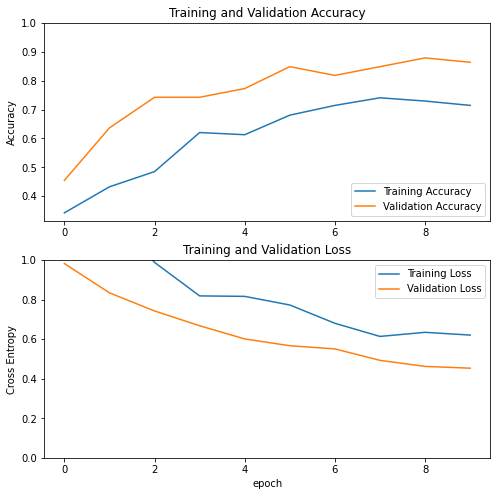

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/18),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)


56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
9/9 [==============================] - 8s 231ms/step - loss: 0.7471 - accuracy: 0.7068 - val_loss: 0.4178 - val_accuracy: 0.8788
Epoch 11/20
9/9 [==============================] - 1s 90ms/step - loss: 0.5481 - accuracy: 0.7820 - val_loss: 0.3388 - val_accuracy: 0.8939
Epoch 12/20
9/9 [==============================] - 1s 89ms/step - loss: 0.4003 - accuracy: 0.8421 - val_loss: 0.2298 - val_accuracy: 0.9394
Epoch 13/20
9/9 [==============================] - 1s 91ms/step - loss: 0.4144 - accuracy: 0.8722 - val_loss: 0.2701 - val_accuracy: 0.9394
Epoch 14/20
9/9 [==============================] - 1s 95ms/step - loss: 0.2841 - accuracy: 0.9060 - val_loss: 0.4624 - val_accuracy: 0.7879
Epoch 15/20
9/9 [==============================] - 1s 89ms/step - loss: 0.2857 - accuracy: 0.8985 - val_loss: 0.2839 - val_accuracy: 0.9242
Epoch 16/20
9/9 [==============================] - 1s 90ms/step - loss: 0.2710 - accuracy: 0.9098 - val_loss: 0.3287 - val_accuracy: 0.9091
Epoch 17/20
9/9 [==

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

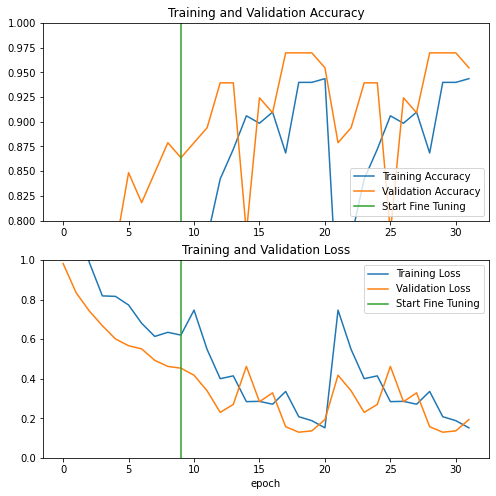

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()